In [242]:
import numpy as np 
import geopandas as gpd 
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import pandas as pd 
from shapely.geometry import shape 
# from shapely.geometry import Polygon 
import json 
from shapely import wkt 
from shapely.geometry import box
from math import cos, radians
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
import seaborn as sns 
import contextily as ctx
import xarray as xr
from pathlib import Path
from shapely.geometry import Polygon, Point

# Section 1: Correlation of fire intensity and environment factors

Fire intensity is measured using the total fire radiative power (GW) derived from satellite products within the study region (see SatelliteFire.ipynb). Environmental factors are represented by variables from the ERA5 dataset, the fifth-generation ECMWF atmospheric reanalysis of the global climate, after preprocessing. This analysis focuses on data from January 7 to January 12, 2025.

In [243]:
# load FRP data
frp_pali = xr.open_dataset("Total_FRP/total_frp_palisades.nc")
frp_eaton = xr.open_dataset("Total_FRP/total_frp_eaton.nc")

In [244]:
# load ERA5 data
era5 = xr.open_dataset("ERA5/ERA_5_Land_Hourly_Data.nc")
# slice to the time period of interest
era5_sliced = era5.sel(valid_time=slice("2025-01-05", "2025-01-13"))

# load fire perimeter
fire_perimeter = gpd.read_file(f"{Path.home()}/WILDFIRE/Cai_Folder/fires_perimeter.geojson")
fire_perimeter = fire_perimeter.to_crs(32611)

In [245]:
# function to clip raster to fire perimeter and take the region-mean (adopted from K.KayDee)
def clip_raster_to_area(arr, reference_gdf):
    
    # Make sure the dataset has CRS information
    arr = arr.rio.write_crs("EPSG:32611")    

    eaton_clipped = arr.rio.clip([reference_gdf.iloc[0].geometry], all_touched=True).mean({'x','y'}) 
    palisades_clipped = arr.rio.clip([reference_gdf.iloc[1].geometry], all_touched=True).mean({'x','y'}) 

    return eaton_clipped, palisades_clipped

### Temperature

In [246]:
# Raster for Palisades & Eaton 
eaton_temp_da, palisades_temp_da = clip_raster_to_area(era5_sliced.t2m, fire_perimeter)

In [247]:
pali_temp_mean = palisades_temp_da.resample(valid_time='1D').mean()
pali_temp_max = palisades_temp_da.resample(valid_time='1D').max()

eaton_temp_mean = eaton_temp_da.resample(valid_time='1D').mean()
eaton_temp_max = eaton_temp_da.resample(valid_time='1D').max()

Text(0, 0.5, '(F)')

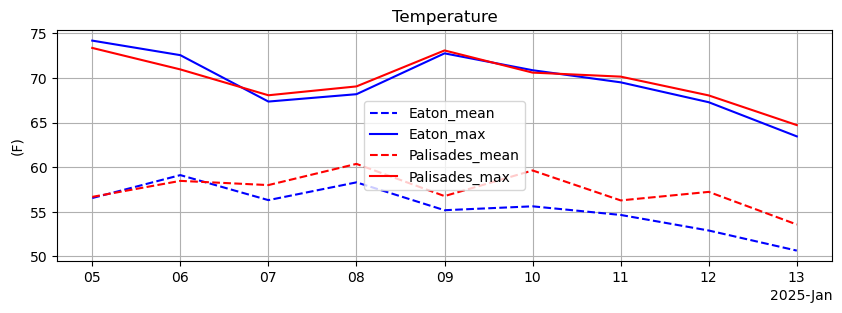

In [248]:
# visualize the daily value

fig,ax = plt.subplots(figsize=(10,3))
eaton_temp_mean.plot(ax=ax, label='Eaton_mean', color='b', linestyle='--')
eaton_temp_max.plot(ax=ax, label='Eaton_max', color='b', linestyle='-')

pali_temp_mean.plot(ax=ax, label='Palisades_mean', color='r', linestyle='--')
pali_temp_max.plot(ax=ax, label='Palisades_max', color='r', linestyle='-')

ax.legend()
ax.grid()
ax.set_title('Temperature')
ax.set_xlabel('')
ax.set_ylabel('(F)')

### Wind Magnitude

In [249]:
# calculate the magnitude
era5_sliced['wind_mag'] = np.sqrt(era5_sliced.u10**2 + era5_sliced.v10**2)
# Raster for Palisades & Eaton 
eaton_wind_da, palisades_wind_da = clip_raster_to_area(era5_sliced.wind_mag, fire_perimeter)

In [250]:
# resample to daily value

pali_wind_mean = palisades_wind_da.resample(valid_time='1D').mean()
pali_wind_max = palisades_wind_da.resample(valid_time='1D').max()

eaton_wind_mean = eaton_wind_da.resample(valid_time='1D').mean()
eaton_wind_max = eaton_wind_da.resample(valid_time='1D').max()

Text(0, 0.5, '(m/s)')

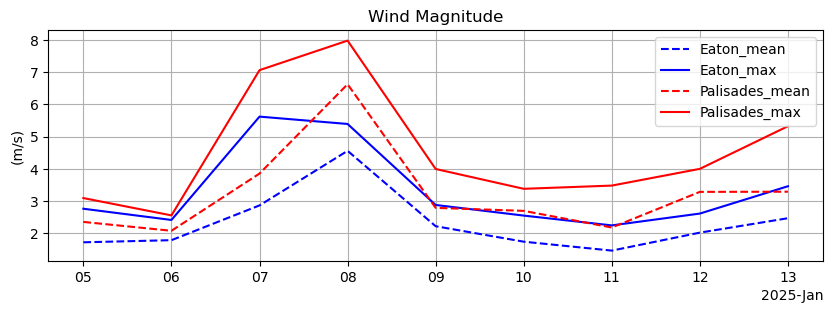

In [251]:
# visualize the daily value

fig,ax = plt.subplots(figsize=(10,3))
eaton_wind_mean.plot(ax=ax, label='Eaton_mean', color='b', linestyle='--')
eaton_wind_max.plot(ax=ax, label='Eaton_max', color='b', linestyle='-')

pali_wind_mean.plot(ax=ax, label='Palisades_mean', color='r', linestyle='--')
pali_wind_max.plot(ax=ax, label='Palisades_max', color='r', linestyle='-')

ax.legend()
ax.grid()
ax.set_title('Wind Magnitude')
ax.set_xlabel('')
ax.set_ylabel('(m/s)')

### Precipitation

In [252]:
# Raster for Palisades & Eaton 
eaton_preci_da, palisades_preci_da = clip_raster_to_area(era5_sliced.tp, fire_perimeter)

In [253]:
# resample to daily value, take the sum for precipitation
pali_preci_sum = palisades_preci_da.resample(valid_time='1D').sum()
eaton_preci_sum = eaton_preci_da.resample(valid_time='1D').sum()

### Specific Humidity
kg of water vapor per kg of air

In [254]:
humidity = xr.open_dataset("ERA5/humidity.nc")

# slice to the time period of interest
humidity_sliced = humidity.sel(valid_time=slice("2025-01-05", "2025-01-13"))

In [255]:
print(humidity_sliced.data_vars)

Data variables:
    __xarray_dataarray_variable__  (valid_time, y, x) float32 247kB ...


In [256]:
# rename the variable for easy call
humidity_sliced = humidity_sliced.rename({"__xarray_dataarray_variable__": "humidity"})

In [257]:
eaton_humi_da, palisades_humi_da = clip_raster_to_area(humidity_sliced.humidity, fire_perimeter)

In [258]:
# resample to daily value

pali_humi_mean = palisades_humi_da.resample(valid_time='1D').mean()
eaton_humi_mean = eaton_humi_da.resample(valid_time='1D').mean()

## Heatmap show correlation

### Palisades

In [259]:
# Convert 'FRP' and 'ACQ_DATE' from the frp_pali dataset to DataFrame
frp_df = frp_pali[['ACQ_DATE', 'FRP']].to_dataframe().reset_index()
frp_df['valid_time'] = pd.to_datetime(frp_df['ACQ_DATE'])

# Convert other variables to DataFrames
pali_temp_mean_df = pali_temp_mean.to_dataframe().reset_index()
pali_temp_mean_df['valid_time'] = pd.to_datetime(pali_temp_mean_df['valid_time'])

pali_wind_mean_df = pali_wind_mean.to_dataframe().reset_index()
pali_wind_mean_df['valid_time'] = pd.to_datetime(pali_wind_mean_df['valid_time'])

pali_preci_sum_df = pali_preci_sum.to_dataframe().reset_index()
pali_preci_sum_df['valid_time'] = pd.to_datetime(pali_preci_sum_df['valid_time'])

pali_humi_mean_df = pali_humi_mean.to_dataframe().reset_index()
pali_humi_mean_df['valid_time'] = pd.to_datetime(pali_humi_mean_df['valid_time'])


# Merge all variables on 'valid_time' (keeping only colocated dates)
merged_data = pd.merge(frp_df, pali_temp_mean_df[['valid_time', 't2m']], on='valid_time', how='inner')
merged_data.rename(columns={'t2m': 'temperature'}, inplace=True)
merged_data = pd.merge(merged_data, pali_wind_mean_df[['valid_time', 'wind_mag']], on='valid_time', how='inner')
merged_data.rename(columns={'wind_mag': 'wind'}, inplace=True)
merged_data = pd.merge(merged_data, pali_preci_sum_df[['valid_time', 'tp']], on='valid_time', how='inner')
merged_data.rename(columns={'tp': 'precipitation'}, inplace=True)
merged_data = pd.merge(merged_data, pali_humi_mean_df[['valid_time', 'humidity']], on='valid_time', how='inner')

# Set 'valid_time' as the index
merged_data.set_index('valid_time', inplace=True)

In [260]:
merged_data_used = merged_data.iloc[:, 2:]
merged_data_used

,FRP,temperature,wind,precipitation,humidity
valid_time,,,,,
2025-01-07,36250.30,57.995342,3.851842,0.030621,0.004814
2025-01-08,106765.81,60.371582,6.625094,0.014252,0.002128
2025-01-09,29653.15,56.760498,2.787510,0.000852,0.002707
2025-01-10,10777.05,59.634369,2.694066,0.022824,0.002112
2025-01-11,29687.54,56.276260,2.176829,0.007265,0.003237
2025-01-12,10.75,57.231873,3.283501,0.000852,0.002449


In [261]:
corr_matrix = merged_data_used.corr()

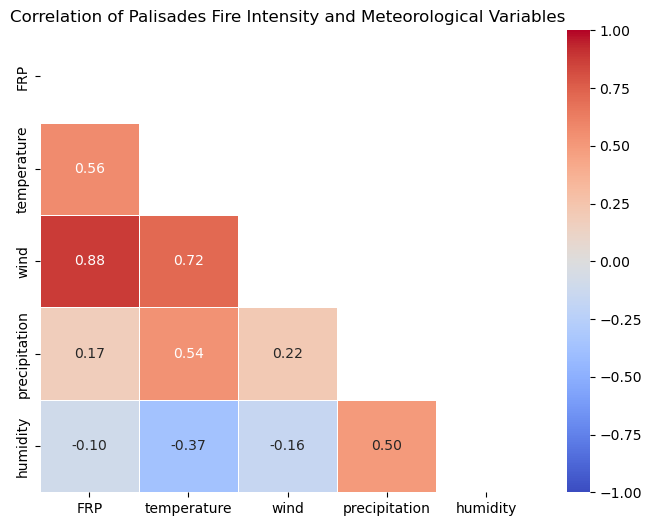

In [262]:
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1, mask=mask)
plt.title("Correlation of Palisades Fire Intensity and Meteorological Variables")

plt.savefig("plots/heatmap_pali_env.png", format="png")
plt.show()

## Is there one-day lead for environment variables?

In [263]:
# Original correlation (without shifting)
corr_with_frp_original = merged_data_used['FRP'].corr(merged_data_used['temperature'])
corr_with_frp_wind_mean_original = merged_data_used['FRP'].corr(merged_data_used['wind'])
corr_with_frp_preci_original = merged_data_used['FRP'].corr(merged_data_used['precipitation'])
corr_with_frp_humi_original = merged_data_used['FRP'].corr(merged_data_used['humidity'])

# Shift the environmental variables by 1 day ahead (lead of 1)
merged_data_used_lead = merged_data_used.shift(-1)

# 1-day ahead (lead) correlation
corr_with_frp_lead = merged_data_used['FRP'].corr(merged_data_used_lead['temperature'])
corr_with_frp_wind_mean = merged_data_used['FRP'].corr(merged_data_used_lead['wind'])
corr_with_frp_preci = merged_data_used['FRP'].corr(merged_data_used_lead['precipitation'])
corr_with_frp_humi = merged_data_used['FRP'].corr(merged_data_used_lead['humidity'])

# Print the original correlations
print("Original Correlation (without lag):")
print(f"Correlation between fire intensity (FRP) and temperature: {corr_with_frp_original:.2f}")
print(f"Correlation between fire intensity (FRP) and wind: {corr_with_frp_wind_mean_original:.2f}")
print(f"Correlation between fire intensity (FRP) and precipitation: {corr_with_frp_preci_original:.2f}")
print(f"Correlation between fire intensity (FRP) and humidity: {corr_with_frp_humi_original:.2f}")

# Print the 1-day ahead (lead) correlations
print("\n1-Day Ahead Correlation (with lag of 1):")
print(f"Correlation between fire intensity (FRP) and 1-day ahead temperature: {corr_with_frp_lead:.2f}")
print(f"Correlation between fire intensity (FRP) and 1-day ahead wind: {corr_with_frp_wind_mean:.2f}")
print(f"Correlation between fire intensity (FRP) and 1-day ahead precipitation: {corr_with_frp_preci:.2f}")
print(f"Correlation between fire intensity (FRP) and 1-day ahead humidity: {corr_with_frp_humi:.2f}")


Original Correlation (without lag):
Correlation between fire intensity (FRP) and temperature: 0.56
Correlation between fire intensity (FRP) and wind: 0.88
Correlation between fire intensity (FRP) and precipitation: 0.17
Correlation between fire intensity (FRP) and humidity: -0.10

1-Day Ahead Correlation (with lag of 1):
Correlation between fire intensity (FRP) and 1-day ahead temperature: -0.19
Correlation between fire intensity (FRP) and 1-day ahead wind: -0.04
Correlation between fire intensity (FRP) and 1-day ahead precipitation: -0.41
Correlation between fire intensity (FRP) and 1-day ahead humidity: -0.03


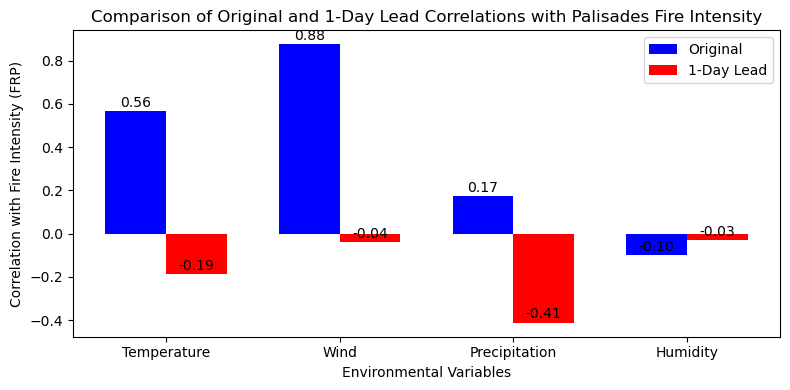

In [264]:
# Data for plotting
variables = ['Temperature', 'Wind', 'Precipitation', 'Humidity']
original_corr = [
    corr_with_frp_original, 
    corr_with_frp_wind_mean_original, 
    corr_with_frp_preci_original, 
    corr_with_frp_humi_original
]
lead_corr = [
    corr_with_frp_lead,  
    corr_with_frp_wind_mean, 
    corr_with_frp_preci, 
    corr_with_frp_humi
]

# Set the positions for the bars on the x-axis
x = np.arange(len(variables))
width = 0.35  # Width of the bars

# Plot
fig, ax = plt.subplots(figsize=(8, 4))

bars1 = ax.bar(x - width/2, original_corr, width, label='Original', color='b')
bars2 = ax.bar(x + width/2, lead_corr, width, label='1-Day Lead', color='r')

ax.set_xlabel('Environmental Variables')
ax.set_ylabel('Correlation with Fire Intensity (FRP)')
ax.set_title('Comparison of Original and 1-Day Lead Correlations with Palisades Fire Intensity')
ax.set_xticks(x)
ax.set_xticklabels(variables)
ax.legend()

# Add the values on top of the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()

plt.savefig("plots/corr_lag_pali_env.png", format="png")
plt.show()


###  It seems that the precipitation is interpolated better with one-day lead correlation

### Eaton

In [265]:
# Convert 'FRP' and 'ACQ_DATE' from the frp_eaton dataset to DataFrame
frp_df = frp_eaton[['ACQ_DATE', 'FRP']].to_dataframe().reset_index()
frp_df['valid_time'] = pd.to_datetime(frp_df['ACQ_DATE'])

# Convert other variables to DataFrames
eaton_temp_mean_df = eaton_temp_mean.to_dataframe().reset_index()
eaton_temp_mean_df['valid_time'] = pd.to_datetime(eaton_temp_mean_df['valid_time'])

eaton_wind_mean_df = eaton_wind_mean.to_dataframe().reset_index()
eaton_wind_mean_df['valid_time'] = pd.to_datetime(eaton_wind_mean_df['valid_time'])

eaton_preci_sum_df = eaton_preci_sum.to_dataframe().reset_index()
eaton_preci_sum_df['valid_time'] = pd.to_datetime(eaton_preci_sum_df['valid_time'])

eaton_humi_mean_df = eaton_humi_mean.to_dataframe().reset_index()
eaton_humi_mean_df['valid_time'] = pd.to_datetime(eaton_humi_mean_df['valid_time'])

# Merge all variables on 'valid_time' (keeping only colocated dates)
merged_data2 = pd.merge(frp_df, eaton_temp_mean_df[['valid_time', 't2m']], on='valid_time', how='inner')
merged_data2.rename(columns={'t2m': 'temperature'}, inplace=True)
merged_data2 = pd.merge(merged_data2, eaton_wind_mean_df[['valid_time', 'wind_mag']], on='valid_time', how='inner')
merged_data2.rename(columns={'wind_mag': 'wind'}, inplace=True)
merged_data2 = pd.merge(merged_data2, eaton_preci_sum_df[['valid_time', 'tp']], on='valid_time', how='inner')
merged_data2.rename(columns={'tp': 'precipitation'}, inplace=True)
merged_data2 = pd.merge(merged_data2, eaton_humi_mean_df[['valid_time', 'humidity']], on='valid_time', how='inner')

# Set 'valid_time' as the index
merged_data2.set_index('valid_time', inplace=True)

In [266]:
merged_data_used2 = merged_data2.iloc[:, 2:]
merged_data_used2

,FRP,temperature,wind,precipitation,humidity
valid_time,,,,,
2025-01-08,41648.26,58.299824,4.558323,0.016599,0.001794
2025-01-09,16754.85,55.176594,2.217243,0.000852,0.001363
2025-01-10,670.43,55.612778,1.736929,0.022824,0.001663
2025-01-11,14.46,54.646992,1.459758,0.007265,0.002160
2025-01-12,18.13,52.900082,2.018023,0.000852,0.001535


In [267]:
corr_matrix = merged_data_used2.corr()

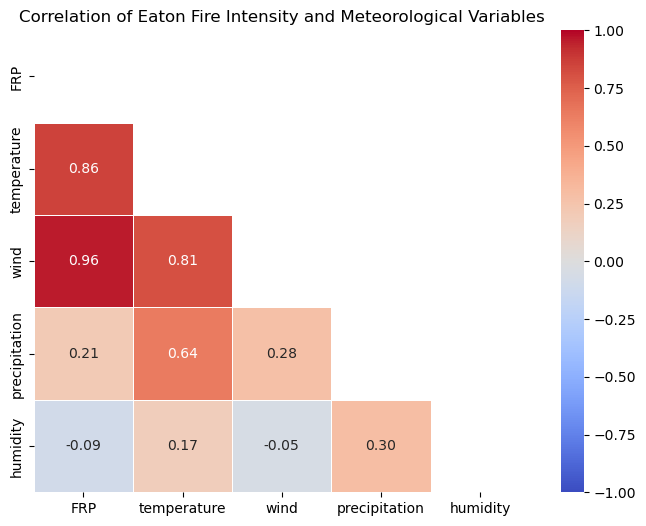

In [268]:
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1, mask=mask)
plt.title("Correlation of Eaton Fire Intensity and Meteorological Variables")

plt.savefig("plots/heatmap_eaton_env.png", format="png")
plt.show()

## Is there one-day lead for environment variables?

In [269]:
# Original correlation (without shifting)
corr_with_frp_original = merged_data_used2['FRP'].corr(merged_data_used['temperature'])
corr_with_frp_wind_mean_original = merged_data_used2['FRP'].corr(merged_data_used['wind'])
corr_with_frp_preci_original = merged_data_used2['FRP'].corr(merged_data_used['precipitation'])
corr_with_frp_humi_original = merged_data_used2['FRP'].corr(merged_data_used['humidity'])

# Shift the environmental variables by 1 day ahead (lead of 1)
merged_data_used_lead = merged_data_used2.shift(-1)

# 1-day ahead (lead) correlation
corr_with_frp_lead = merged_data_used2['FRP'].corr(merged_data_used_lead['temperature'])
corr_with_frp_wind_mean = merged_data_used2['FRP'].corr(merged_data_used_lead['wind'])
corr_with_frp_preci = merged_data_used2['FRP'].corr(merged_data_used_lead['precipitation'])
corr_with_frp_humi = merged_data_used2['FRP'].corr(merged_data_used_lead['humidity'])

# Print the original correlations
print("Original Correlation (without lag):")
print(f"Correlation between fire intensity (FRP) and temperature: {corr_with_frp_original:.2f}")
print(f"Correlation between fire intensity (FRP) and wind: {corr_with_frp_wind_mean_original:.2f}")
print(f"Correlation between fire intensity (FRP) and precipitation: {corr_with_frp_preci_original:.2f}")
print(f"Correlation between fire intensity (FRP) and humidity: {corr_with_frp_humi_original:.2f}")

# Print the 1-day ahead (lead) correlations
print("\n1-Day Ahead Correlation (with lag of 1):")
print(f"Correlation between fire intensity (FRP) and 1-day ahead temperature: {corr_with_frp_lead:.2f}")
print(f"Correlation between fire intensity (FRP) and 1-day ahead wind: {corr_with_frp_wind_mean:.2f}")
print(f"Correlation between fire intensity (FRP) and 1-day ahead precipitation: {corr_with_frp_preci:.2f}")
print(f"Correlation between fire intensity (FRP) and 1-day ahead humidity: {corr_with_frp_humi:.2f}")


Original Correlation (without lag):
Correlation between fire intensity (FRP) and temperature: 0.57
Correlation between fire intensity (FRP) and wind: 0.90
Correlation between fire intensity (FRP) and precipitation: 0.12
Correlation between fire intensity (FRP) and humidity: -0.41

1-Day Ahead Correlation (with lag of 1):
Correlation between fire intensity (FRP) and 1-day ahead temperature: 0.60
Correlation between fire intensity (FRP) and 1-day ahead wind: 0.65
Correlation between fire intensity (FRP) and 1-day ahead precipitation: -0.08
Correlation between fire intensity (FRP) and 1-day ahead humidity: -0.66


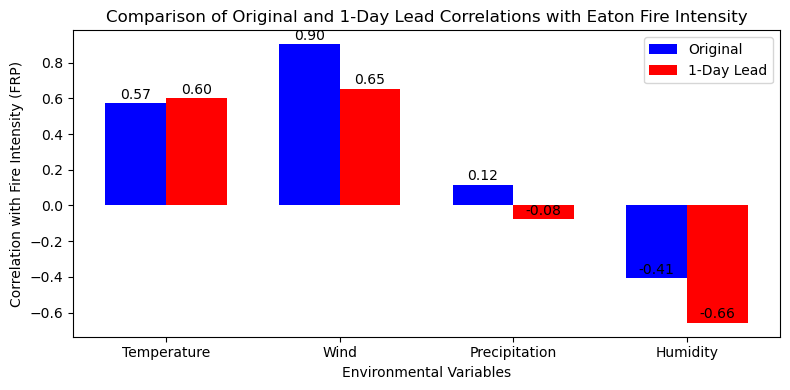

In [270]:
# Data for plotting
variables = ['Temperature', 'Wind', 'Precipitation', 'Humidity']
original_corr = [
    corr_with_frp_original, 
    corr_with_frp_wind_mean_original, 
    corr_with_frp_preci_original, 
    corr_with_frp_humi_original
]
lead_corr = [
    corr_with_frp_lead,  
    corr_with_frp_wind_mean, 
    corr_with_frp_preci, 
    corr_with_frp_humi
]

# Set the positions for the bars on the x-axis
x = np.arange(len(variables))
width = 0.35  # Width of the bars

# Plot
fig, ax = plt.subplots(figsize=(8, 4))

bars1 = ax.bar(x - width/2, original_corr, width, label='Original', color='b')
bars2 = ax.bar(x + width/2, lead_corr, width, label='1-Day Lead', color='r')

ax.set_xlabel('Environmental Variables')
ax.set_ylabel('Correlation with Fire Intensity (FRP)')
ax.set_title('Comparison of Original and 1-Day Lead Correlations with Eaton Fire Intensity')
ax.set_xticks(x)
ax.set_xticklabels(variables)
ax.legend()

# Add the values on top of the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()

plt.savefig("plots/corr_lag_eaton_env.png", format="png")
plt.show()


### Now it turns to humidity for Eaton. More further analysis to understand the role of precipitation and humidity on fire

# Section 2: Correlation of fire intensity and air quality

Air quality are represented by air pollutants time series in Los Angeles. This analysis focuses on data from January 7 to January 12, 2025.

In [271]:
la_air = xr.open_dataset('LA_air.nc')
air_df = la_air.to_dataframe().reset_index()

#### Palisades

In [292]:
# get the fire intensity
merged_data_selected = merged_data[['FRP', 'ACQ_DATE']].copy()

merged_data_selected['ACQ_DATE'] = pd.to_datetime(merged_data_selected['ACQ_DATE'])

# Merge with the air pollutant data
merged_data_pollutants = pd.merge(merged_data_selected, air_df[['date', 'pm2.5', 'pm10']], 
                                  left_on='ACQ_DATE', right_on='date', how='inner')

merged_data_pollutants.drop(columns=['date'], inplace=True)
merged_data_pollutants.set_index('ACQ_DATE', inplace=True)

In [273]:
merged_data_pollutants

,FRP,pm2.5,pm10
ACQ_DATE,,,
2025-01-07,36250.30,36.0,84.0
2025-01-08,106765.81,52.0,167.0
2025-01-09,29653.15,177.0,87.0
2025-01-10,10777.05,159.0,61.0
2025-01-11,29687.54,101.0,53.0
2025-01-12,10.75,84.0,37.0


In [274]:
corr_matrix = merged_data_pollutants.corr()

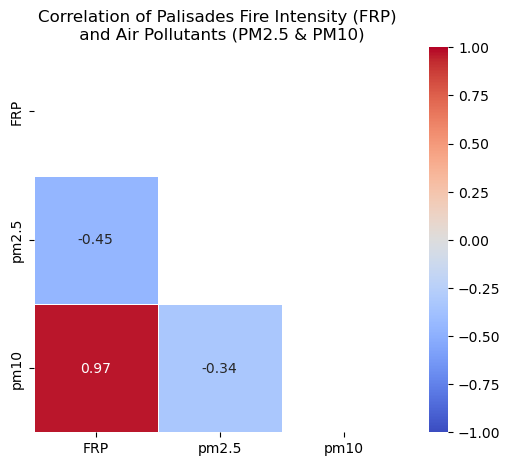

In [275]:
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1, mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
plt.title("Correlation of Palisades Fire Intensity (FRP) \n and Air Pollutants (PM2.5 & PM10)")

# Save the plot
plt.savefig("plots/heatmap_pali_pollutants.png", format="png")
plt.show()

#### Strange about the low and NEGATIVE correlation of pm2.5. Let's try day shifting.

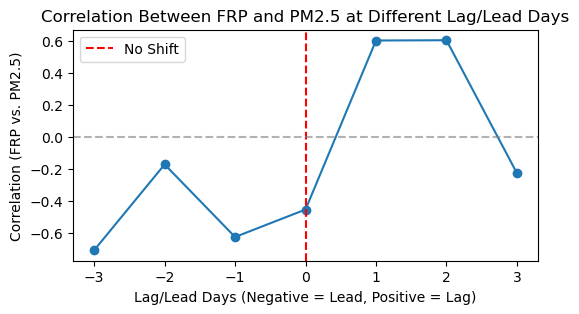

In [293]:
# Define the range of lags/leads (negative for lead, positive for lag)
max_lag = 3  # Adjust as needed
lags = np.arange(-max_lag, max_lag + 1)  # Includes both lead (-) and lag (+)
correlations = []

for lag in lags:
    if lag < 0:  # Lead (PM2.5 shifts forward)
        merged_data_pollutants[f'pm2.5_lead{abs(lag)}'] = merged_data_pollutants['pm2.5'].shift(abs(lag))
        corr_value = merged_data_pollutants[['FRP', f'pm2.5_lead{abs(lag)}']].corr().iloc[0, 1]
    else:  # Lag (PM2.5 shifts backward)
        merged_data_pollutants[f'pm2.5_lag{lag}'] = merged_data_pollutants['pm2.5'].shift(-lag)
        corr_value = merged_data_pollutants[['FRP', f'pm2.5_lag{lag}']].corr().iloc[0, 1]
    
    correlations.append(corr_value)

# Plot the correlation vs. lag/lead days
plt.figure(figsize=(6, 3))
plt.plot(lags, correlations, marker='o', linestyle='-')
plt.axvline(0, color='red', linestyle='--', label='No Shift')
plt.xlabel('Lag/Lead Days (Negative = Lead, Positive = Lag)')
plt.ylabel('Correlation (FRP vs. PM2.5)')
plt.title('Correlation Between FRP and PM2.5 at Different Lag/Lead Days')
plt.axhline(0, color='gray', linestyle='--', alpha=0.6)
plt.legend()
plt.show()


In [294]:
# Compute 1-day lag correlation
merged_data_pollutants['pm2.5_lag1'] = merged_data_pollutants['pm2.5'].shift(-1)
corr_lag1 = merged_data_pollutants[['FRP', 'pm2.5_lag1']].corr().iloc[0, 1]

# Compute 2-day lag correlation
merged_data_pollutants['pm2.5_lag2'] = merged_data_pollutants['pm2.5'].shift(-2)
corr_lag2 = merged_data_pollutants[['FRP', 'pm2.5_lag2']].corr().iloc[0, 1]

# Print results
print("One-day lag correlation (FRP vs. PM2.5):", corr_lag1)
print("Two-day lag correlation (FRP vs. PM2.5):", corr_lag2)

One-day lag correlation (FRP vs. PM2.5): 0.6007497711130294
Two-day lag correlation (FRP vs. PM2.5): 0.6025749284225834


#### RESULT: One-day or two-day Lag of PM2.5 have the high correlation with fire corr = 0.6.

#### Eaton

In [295]:
# get the fire intensity
merged_data_selected = merged_data2[['FRP', 'ACQ_DATE']].copy()

merged_data_selected['ACQ_DATE'] = pd.to_datetime(merged_data_selected['ACQ_DATE'])

# Merge with the air pollutant data
merged_data_pollutants = pd.merge(merged_data_selected, air_df[['date', 'pm2.5', 'pm10']], 
                                  left_on='ACQ_DATE', right_on='date', how='inner')

merged_data_pollutants.drop(columns=['date'], inplace=True)
merged_data_pollutants.set_index('ACQ_DATE', inplace=True)

In [296]:
merged_data_pollutants

,FRP,pm2.5,pm10
ACQ_DATE,,,
2025-01-08,41648.26,52.0,167.0
2025-01-09,16754.85,177.0,87.0
2025-01-10,670.43,159.0,61.0
2025-01-11,14.46,101.0,53.0
2025-01-12,18.13,84.0,37.0


In [278]:
corr_matrix = merged_data_pollutants.corr()

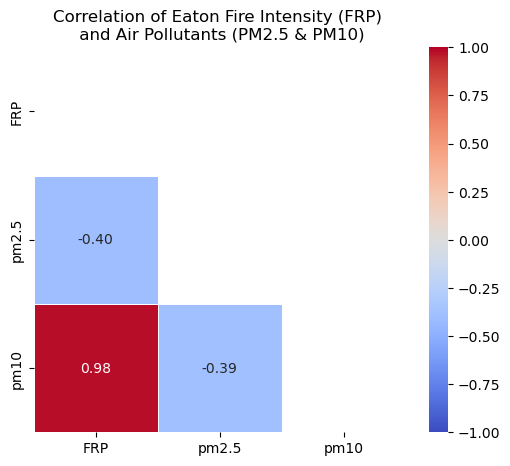

In [279]:
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1, mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
plt.title("Correlation of Eaton Fire Intensity (FRP) \n and Air Pollutants (PM2.5 & PM10)")

# Save the plot
plt.savefig("plots/heatmap_eaton_pollutants.png", format="png")
plt.show()

#### Apply similar shifting to PM2.5 in Eaton

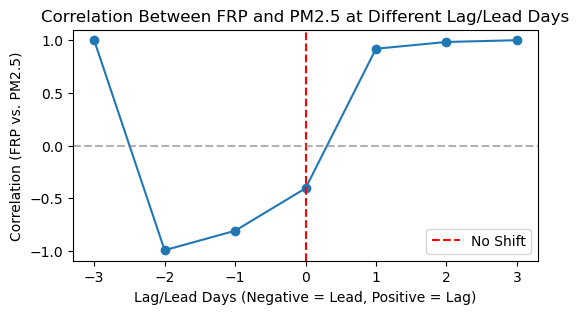

In [297]:
# Define the range of lags/leads (negative for lead, positive for lag)
max_lag = 3  # Adjust as needed
lags = np.arange(-max_lag, max_lag + 1)  # Includes both lead (-) and lag (+)
correlations = []

for lag in lags:
    if lag < 0:  # Lead (PM2.5 shifts forward)
        merged_data_pollutants[f'pm2.5_lead{abs(lag)}'] = merged_data_pollutants['pm2.5'].shift(abs(lag))
        corr_value = merged_data_pollutants[['FRP', f'pm2.5_lead{abs(lag)}']].corr().iloc[0, 1]
    else:  # Lag (PM2.5 shifts backward)
        merged_data_pollutants[f'pm2.5_lag{lag}'] = merged_data_pollutants['pm2.5'].shift(-lag)
        corr_value = merged_data_pollutants[['FRP', f'pm2.5_lag{lag}']].corr().iloc[0, 1]
    
    correlations.append(corr_value)

# Plot the correlation vs. lag/lead days
plt.figure(figsize=(6, 3))
plt.plot(lags, correlations, marker='o', linestyle='-')
plt.axvline(0, color='red', linestyle='--', label='No Shift')
plt.xlabel('Lag/Lead Days (Negative = Lead, Positive = Lag)')
plt.ylabel('Correlation (FRP vs. PM2.5)')
plt.title('Correlation Between FRP and PM2.5 at Different Lag/Lead Days')
plt.axhline(0, color='gray', linestyle='--', alpha=0.6)
plt.legend()
plt.show()


In [298]:
# Compute 1-day lag correlation
merged_data_pollutants['pm2.5_lag1'] = merged_data_pollutants['pm2.5'].shift(-1)
corr_lag1 = merged_data_pollutants[['FRP', 'pm2.5_lag1']].corr().iloc[0, 1]

# Compute 2-day lag correlation
merged_data_pollutants['pm2.5_lag2'] = merged_data_pollutants['pm2.5'].shift(-2)
corr_lag2 = merged_data_pollutants[['FRP', 'pm2.5_lag2']].corr().iloc[0, 1]

# Print results
print("One-day lag correlation (FRP vs. PM2.5):", corr_lag1)
print("Two-day lag correlation (FRP vs. PM2.5):", corr_lag2)

One-day lag correlation (FRP vs. PM2.5): 0.9192173091543407
Two-day lag correlation (FRP vs. PM2.5): 0.9834398840186962


#### RESULT, the correlation get close to 0.92 for one-day lag, and even higher for two-day lag at Eaton. That means, there are lag response for pm2.5 and the effect of the pollutants last for more than one day.